**Pre-requisites**

In [ ]:
#require imports
%pip install yfinance cvxopt
import cvxpy as cp

import pandas as pd
import yfinance as yf
import datetime
import numpy as np
import matplotlib.pyplot as plt

import yfinance as yf

In [ ]:
market= "^CRSLDX" #market index NIFTY-500
end_date = '2024-09-23' #end date (3months = 62 business days)
start_date = '2024-01-01' #start date
market = yf.download(market, start=start_date, end=end_date)['Close']
market = market.pct_change().dropna() #calc simple returns
market


[*********************100%***********************]  1 of 1 completed


,Close
Date,
2024-01-03,-0.002639
2024-01-04,0.008989
2024-01-05,0.002525
2024-01-08,-0.008826
2024-01-09,0.002155
...,...
2024-09-16,0.001672
2024-09-17,0.000071
2024-09-18,-0.002972


## **2. Defining the stock universe:**
We pick the 18 NSE stocks and use their closing price to obtain simple returns.

In [ ]:
ticker = [
    'APOLLOTYRE.NS',
    'ASHOKLEY.NS',
    'COFFEEDAY.NS',
    'EQUITASBNK.NS',
    'HDFCBANK.NS',
    'IDFCFIRSTB.NS',
    'ITC.NS',
    'LTF.NS',
    'M&MFIN.NS',
    'MANAPPURAM.NS',
    'MOTHERSON.NS',
    'MSUMI.NS',
    'OIL.NS',
    'SBIN.NS',
    'SUNTECK.NS',
    'TATAMOTORS.NS',
    'TRIDENT.NS',
    'ZOMATO.NS'
]
prices = yf.download(ticker, start=start_date, end=end_date)['Close']  #closing price
returns = prices.pct_change().dropna()  #cal simple returns

[*********************100%***********************]  18 of 18 completed


In [ ]:
#cal mu or expected returns & sigma or risk of the assets
mu = returns.mean()
Sigma = returns.cov()
mu.shape

(18,)

## **3. Visualising the data**

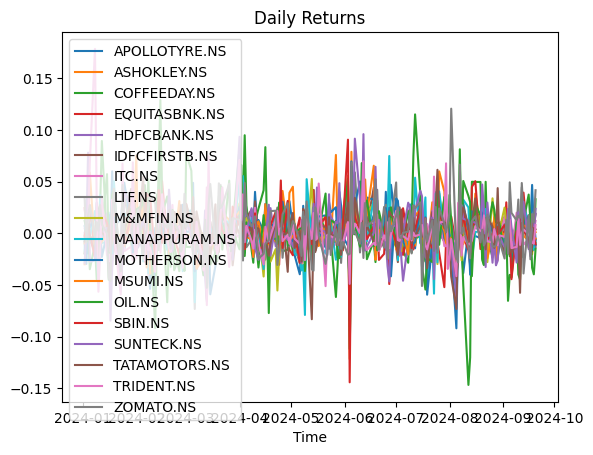

<Figure size 10000x10000 with 0 Axes>

In [ ]:
for col in returns.columns:
  plt.plot(returns[col], label=col)
plt.title("Daily Returns")
plt.xlabel("Time")
plt.legend()
plt.figure(figsize=(100, 100))
plt.show()


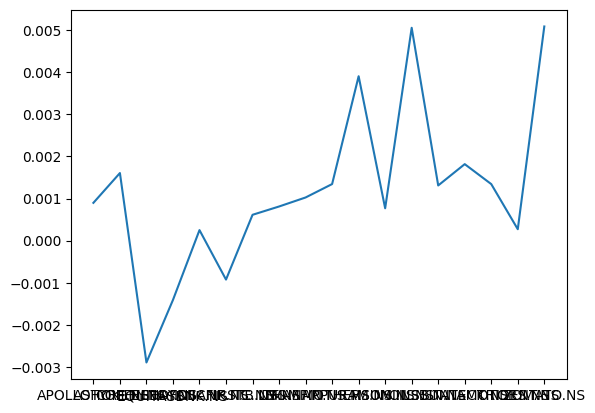

In [ ]:
plt.plot(mu)

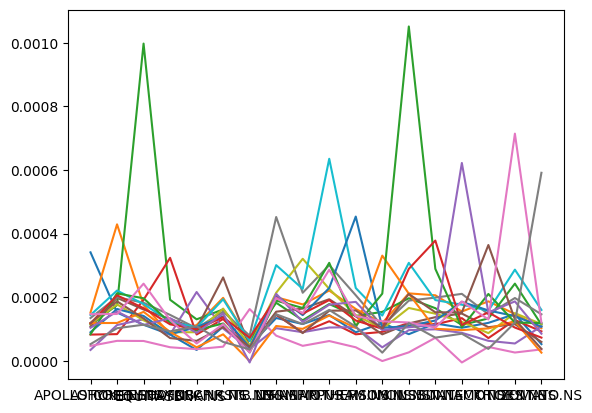

In [ ]:
plt.plot(Sigma)

## **4. Markowitz Portfolio Theory**

In [ ]:
c= np.array(Sigma)
c.shape

(18, 18)

### **A. Markowitz Bullet**

In [ ]:
#calc weights
def rand_weights(n):
    k = np.random.rand(n)
    return k / sum(k)

sigmas=[]
mus=[]
for i in range(10000):
  w= rand_weights(18)
  mu1= np.array(mu)@w.T
  sigma= w@c@w.T
  # print(mu1)
  if(sigma>2):
    i-=1
  else:
    sigmas.append(sigma**0.5)
    mus.append(mu1)


[[1.51161783e-01 1.07100538e+01]
 [1.07100538e+01 1.32861134e+04]]


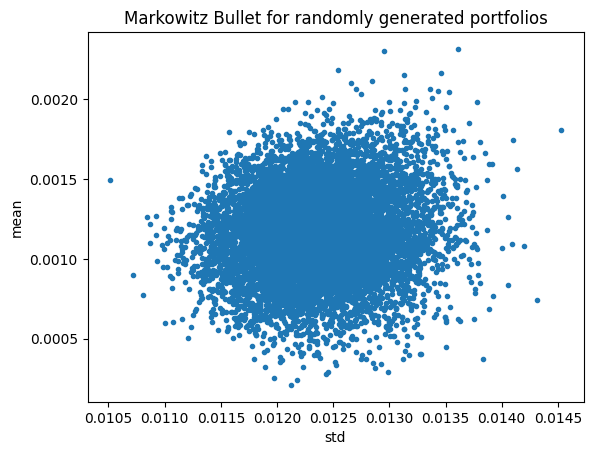

In [ ]:
#plot
u=np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])


plt.plot(sigmas, mus, '.')
M=np.array([[mu@np.linalg.inv(c) @mu.T, u@np.linalg.inv(c)@mu.T],[mu@np.linalg.inv(c)@u.T, u@np.linalg.inv(c)@u.T]])

plt.xlabel('std')
plt.ylabel('mean')
plt.title('Markowitz Bullet for randomly generated portfolios')
print(M)
# py.iplot_mpl(fig, filename='mean_std', strip_style=True)

### **B. Markowitz Efficient Frontier**

In [ ]:
mu= np.array(mu)
mu_min= min(mu)
mu_max= max(mu)
n_assets = 18
w = cp.Variable(n_assets)
target_sigma = cp.Parameter(nonneg=True)

mu1 = mu @ w  # expected return
objective = cp.Maximize(mu1)
constraints = [cp.sum(w) == 1, cp.quad_form(w, c) <= target_sigma**2]

frontier_weights = []
frontier_returns = []

for sigma in sigmas:
    target_sigma.value = sigma
    problem = cp.Problem(objective, constraints)
    try:
        problem.solve(solver=cp.ECOS)
        if problem.status == 'optimal':
            frontier_weights.append(w.value)
            frontier_returns.append(mu1.value)
    except:
        continue




/usr/local/lib/python3.10/dist-packages/cvxpy/reductions/solvers/solving_chain.py:237: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)
/usr/local/lib/python3.10/dist-packages/cvxpy/reductions/solvers/solving_chain.py:356: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add ECOS as an explicit install dependency to your project
    or switch to our new default solver, Clarabel, by either not specifying a
    solver argument or specifying ``solver=cp.CLARABEL``. To suppress this
    warning while continuing to use ECOS, you can filter this warning using
    Python's ``warnings`` module until

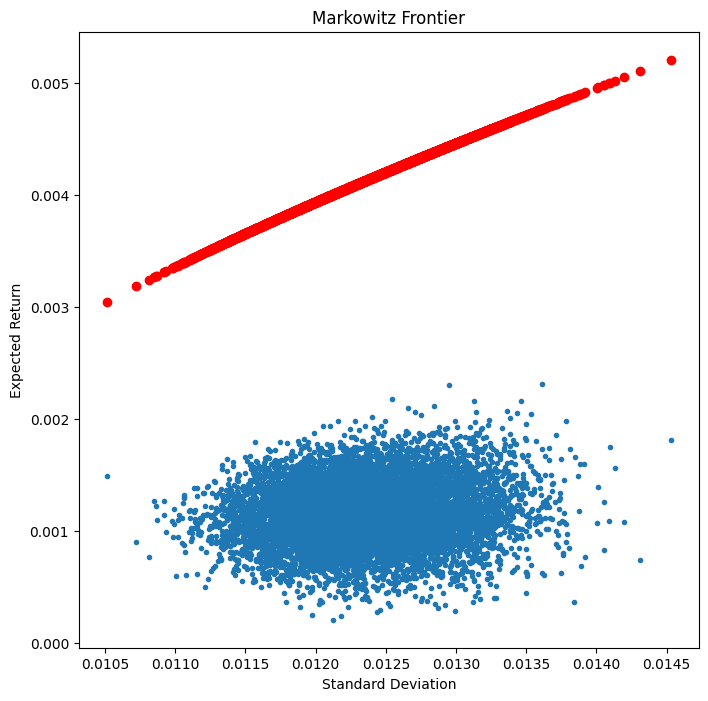

In [ ]:
#plot
plt.subplots(figsize=(8,8))
plt.scatter(sigmas, frontier_returns,c='r')
plt.plot(sigmas, mus, '.')
plt.title('Markowitz Frontier')
plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
plt.show()

## **5. Capital Market Line**

In [ ]:
data={'Returns':frontier_returns,'Volatility':sigmas}  # resturns and standard deviation for 1000 portfolios
portfolios_V1=pd.DataFrame(data)
print(portfolios_V1.shape)
portfolios_V1.head()

(10000, 2)


,Returns,Volatility
0,0.004075,0.012258
1,0.003904,0.011942
2,0.003940,0.012008
3,0.004087,0.012280
4,0.004196,0.012485


In [ ]:
min_vol_port=portfolios_V1.iloc[portfolios_V1['Volatility'].idxmin()]      # point at which standard deviation (risk/sigma) is minimum
min_vol_port

,306
Returns,0.003049
Volatility,0.010514


In [ ]:
rf=0.00074   # return of risk free asset
optimal_risky_port=portfolios_V1.iloc[((portfolios_V1['Returns']-rf)/portfolios_V1['Volatility']).idxmax()]  ## point for which slope(Sharpe ratio) is maximum
print(optimal_risky_port)

Returns       0.005206
Volatility    0.014528
Name: 2845, dtype: float64


<ipython-input-17-a6ce38dfcdef>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(min_vol_port[1],min_vol_port[0],color='y',marker='*',s=500)
<ipython-input-17-a6ce38dfcdef>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(optimal_risky_port[1],optimal_risky_port[0],color='b',marker='*',s=500)


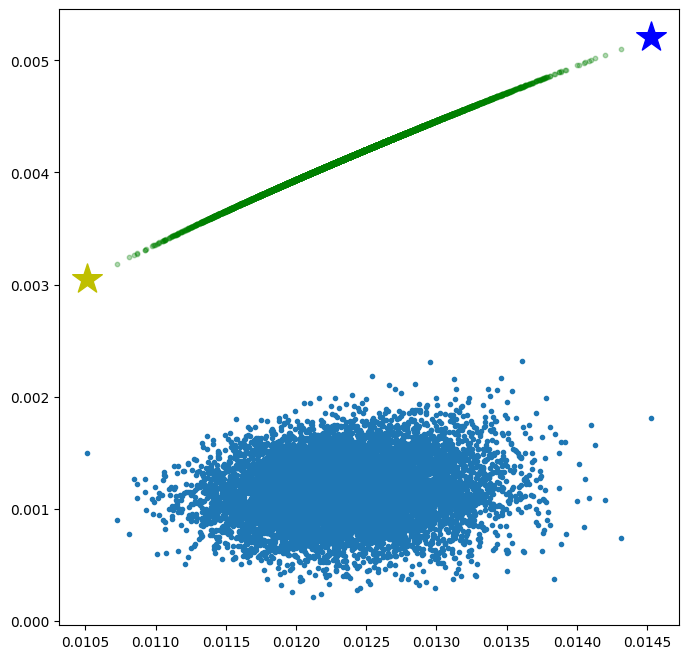

In [ ]:
plt.subplots(figsize=(8,8))
plt.scatter(portfolios_V1['Volatility'],portfolios_V1['Returns'],marker='o',s=10,alpha=0.3,color='green')
plt.scatter(min_vol_port[1],min_vol_port[0],color='y',marker='*',s=500)
plt.scatter(optimal_risky_port[1],optimal_risky_port[0],color='b',marker='*',s=500)
plt.plot(sigmas, mus, '.')

In [ ]:
market_mu=np.mean(market)
print(market_mu)
market_sigma=np.sqrt(np.var(market))
print(market_sigma)

0.0013064795631406608
0.009866925352912819


In [ ]:
cal_x1 = []
cal_y1 = []

cal_x2 = []
cal_y2 = []


In [ ]:
#
for er in np.linspace(rf, max(frontier_returns), 20):
    sd = (er - rf)/((optimal_risky_port[0]-rf)/optimal_risky_port[1])  # getting the value of std ( on x-axis) for corresponding expected_return/mean (on y-axis).
    cal_x1.append(sd)
    cal_y1.append(er)


for er in np.linspace(rf, max(frontier_returns), 20):
    sd = (er - rf)/((market_mu-rf)/market_sigma)  # getting the value of std ( on x-axis) for corresponding expected_return/mean (on y-axis).
    cal_x2.append(sd)
    cal_y2.append(er)



<ipython-input-20-8495d8c0d8e8>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sd = (er - rf)/((optimal_risky_port[0]-rf)/optimal_risky_port[1])  # getting the value of std ( on x-axis) for corresponding expected_return/mean (on y-axis).


Use a risk-free asset along with the 10 risky assets to obtain CAP"M". Draw the straight line and show that it is tangent to the efficient frontier. Obtain the market portfolio.

Slope of Capital Market Line is : 0.3073729358281463


<ipython-input-21-8ae96144386e>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(min_vol_port[1], min_vol_port[0], color='g',marker='*',s=500)
<ipython-input-21-8ae96144386e>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='y',marker='*',s=500)
<ipython-input-21-8ae96144386e>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope=(optimal_risky_port[0]-rf)

Text(0.5, 1.0, 'Capital Asset Pricing Model')

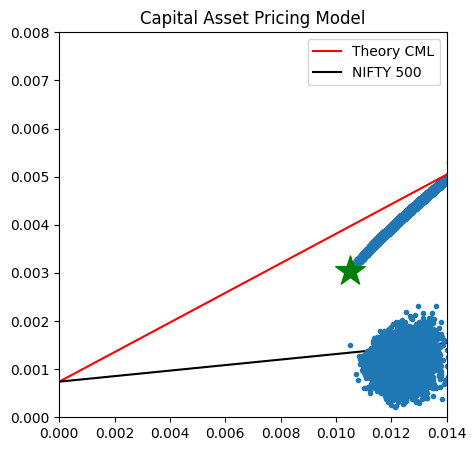

In [ ]:
plt.subplots(figsize=(5,5))
plt.scatter(portfolios_V1['Volatility'], portfolios_V1['Returns'])
plt.scatter(min_vol_port[1], min_vol_port[0], color='g',marker='*',s=500)
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='y',marker='*',s=500)
plt.xlim(0,0.014)
plt.ylim(0,0.008)
plt.plot(cal_x1, cal_y1, color='r', label='Theory CML')  # plotting capital market line

plt.plot(cal_x2, cal_y2, color='black',label= 'NIFTY 500')

plt.plot(sigmas, mus, '.')
slope=(optimal_risky_port[0]-rf)/optimal_risky_port[1]
# title="Slope of line :  "+str(slope)
print("Slope of Capital Market Line is :",slope)
plt.legend()


plt.title('Capital Asset Pricing Model')

## **6. Security Market Line**

In [ ]:
R_f = 0.00074 # risk-free rate - (6 month bond yield of Indian government)

end_date = '2024-09-23'
start_date = '2024-01-01'

market = yf.download("^NSEI", start=start_date, end=end_date)['Close']
market_returns = market.pct_change().dropna()

R_m = market_returns.mean() # expected market return E(R_mkt)

tickers = [
    'APOLLOTYRE.NS',
    'ASHOKLEY.NS',
    'COFFEEDAY.NS',
    'EQUITASBNK.NS',
    'HDFCBANK.NS',
    'IDFCFIRSTB.NS',
    'ITC.NS',
    'LTF.NS',
    'M&MFIN.NS',
    'MANAPPURAM.NS',
    'MOTHERSON.NS',
    'MSUMI.NS',
    'OIL.NS',
    'SBIN.NS',
    'SUNTECK.NS',
    'TATAMOTORS.NS',
    'TRIDENT.NS',
    'ZOMATO.NS'
]
stocks = yf.download(tickers, start=start_date, end=end_date)['Close']
stock_returns = stocks.pct_change().dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  18 of 18 completed


In [ ]:
# getting beta value for each stock using linear regression
def get_beta(stock_name):
  b, a = np.polyfit(market_returns, stock_returns[stock_name], 1)
  return b

In [ ]:
stock_data = pd.DataFrame()
stock_data['stock'] = ticker
stock_data['expected_returns'] = np.array(stock_returns.mean()) # E(R_i) - mean of original returns
stock_data['beta'] = [get_beta(i) for i in tickers]

In [ ]:
stock_data

,stock,expected_returns,beta
0,APOLLOTYRE.NS,0.000898,0.813177
1,ASHOKLEY.NS,0.001606,1.463240
2,COFFEEDAY.NS,-0.002894,1.114295
3,EQUITASBNK.NS,-0.001409,0.738350
4,HDFCBANK.NS,0.000251,0.994098
5,IDFCFIRSTB.NS,-0.000925,1.050385
6,ITC.NS,0.000614,0.658650
7,LTF.NS,0.000811,1.435539
8,M&MFIN.NS,0.001026,1.102267
9,MANAPPURAM.NS,0.001344,1.521137


In [ ]:
def SML(rf,rm,label):
    betas = [x/10 for x in range(3,17)]
    assetReturns = [rf+(rm-rf)*x for x in betas]
    plt.plot(betas,assetReturns,label=label, color = 'black')
    plt.xlabel("Asset Beta")
    plt.ylabel("Asset Return")
    plt.title("Security Market Line")
    plt.plot(1,rm,"ro")

def SML_point(stock, R_f, R_m):
  plt.scatter(stock['beta'], stock['expected_returns'], label=f"{stock['stock']}" )
  on_sml = R_f + stock['beta']*(R_m - R_f) # returns estimated using sml
  plt.scatter(stock['beta'], on_sml,  color = 'grey', alpha = 0.7)
  plt.vlines(x=stock['beta'], ymin=min(stock['expected_returns'], on_sml), ymax=max(stock['expected_returns'], on_sml), colors='grey', ls='--', lw=1.5, alpha = 0.7)

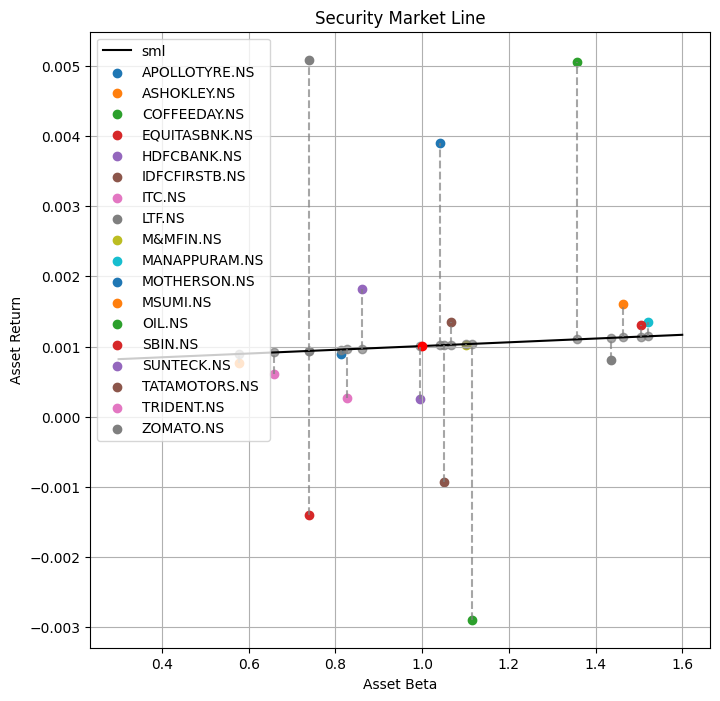

In [ ]:
plt.figure(figsize=(8,8))
SML(R_f, R_m, 'sml')
for i in range(18):
  SML_point(stock_data.iloc[i], R_f, R_m)
plt.legend()
plt.grid()
plt.show()



- Any security priced above the SML is deemed to be undervalued since investors expect a higher return given the same amount of risk. Conversely, any security priced below the SML is deemed to be overvalued




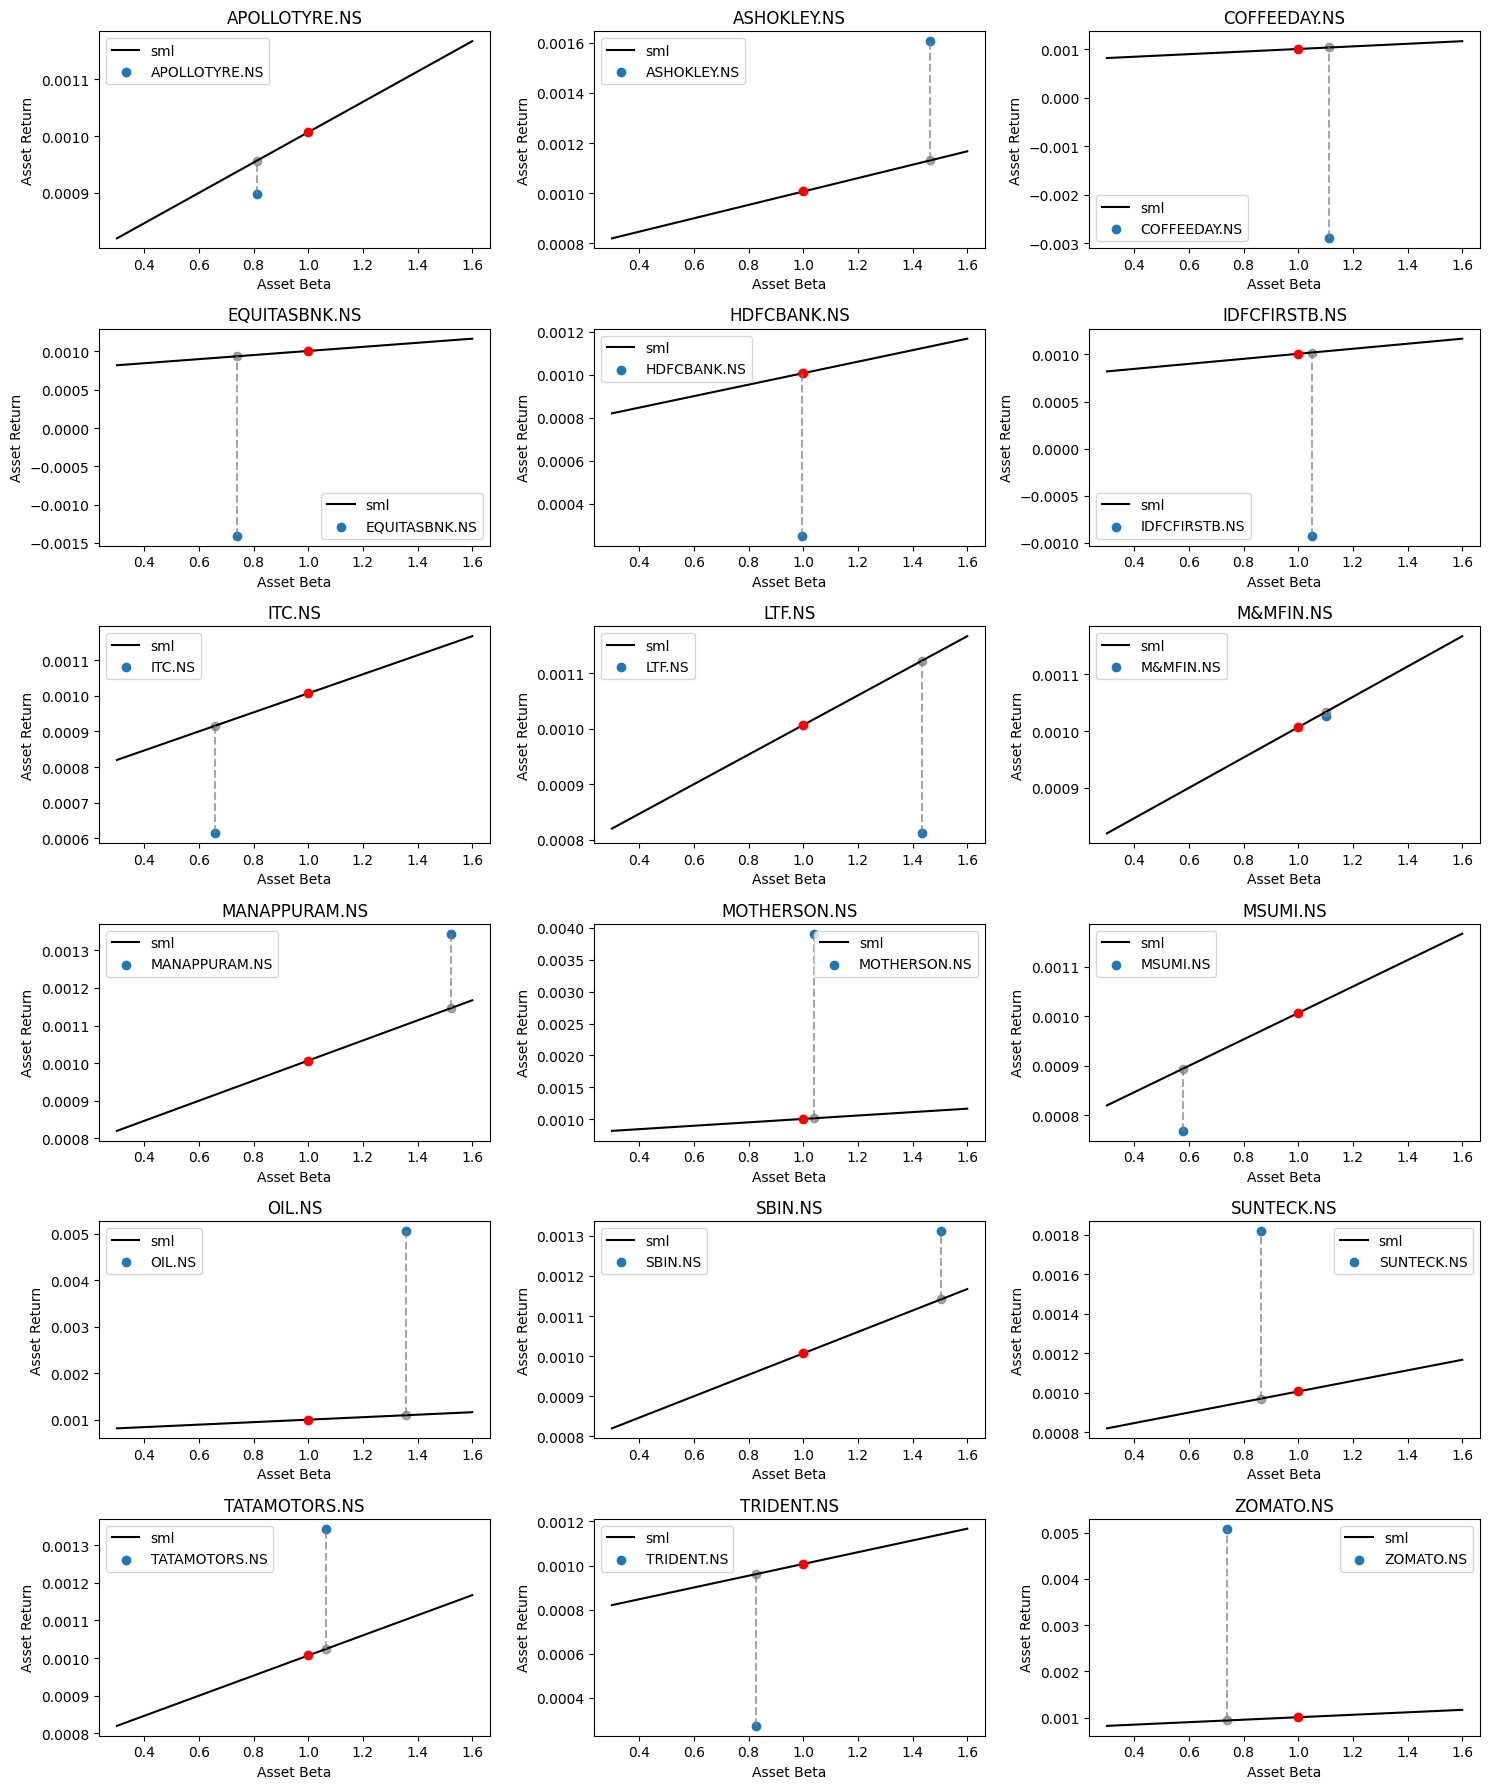

In [ ]:
import matplotlib.pyplot as plt

# Set the number of rows and columns for the grid
n_rows = 6
n_cols = 3

# Create a new figure
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 18))

for i in range(18):
    stock = stock_data.iloc[i]

    # Create a new subplot for each stock
    plt.subplot(n_rows, n_cols, i + 1)

    # Call your SML and SML_point functions
    SML(R_f, R_m, 'sml')
    SML_point(stock, R_f, R_m)

    # Customize the subplot
    plt.legend()
    plt.title(f'{stock["stock"]}')

# Adjust layout
plt.tight_layout()
plt.show()


Respective weights for minimum volatility and optimal risky portfolio

In [ ]:
# Get the weights from the respective portfolios
min_vol_weights = frontier_weights[portfolios_V1['Volatility'].idxmin()]
optimal_risky_weights = frontier_weights[((portfolios_V1['Returns'] - rf) / portfolios_V1['Volatility']).idxmax()]

# Create dictionaries to hold share and weight information
min_vol_portfolio = {tickers[i]: min_vol_weights[i] for i in range(len(tickers))}
optimal_risky_portfolio = {tickers[i]: optimal_risky_weights[i] for i in range(len(tickers))}

# Print the results
print("Minimum Volatility Portfolio Weights:")
for share, weight in min_vol_portfolio.items():
    print(f"{share}: {weight:.4f}")

print("\nOptimal Risky Portfolio Weights:")
for share, weight in optimal_risky_portfolio.items():
    print(f"{share}: {weight:.4f}")

Minimum Volatility Portfolio Weights:
APOLLOTYRE.NS: 0.0929
ASHOKLEY.NS: -0.0152
COFFEEDAY.NS: -0.0857
EQUITASBNK.NS: -0.0502
HDFCBANK.NS: 0.1079
IDFCFIRSTB.NS: -0.0907
ITC.NS: 0.4284
LTF.NS: -0.1355
M&MFIN.NS: 0.0688
MANAPPURAM.NS: -0.0755
MOTHERSON.NS: 0.1795
MSUMI.NS: 0.1421
OIL.NS: 0.0881
SBIN.NS: 0.0069
SUNTECK.NS: 0.0917
TATAMOTORS.NS: 0.0386
TRIDENT.NS: 0.0215
ZOMATO.NS: 0.1863

Optimal Risky Portfolio Weights:
APOLLOTYRE.NS: 0.1203
ASHOKLEY.NS: 0.0398
COFFEEDAY.NS: -0.1384
EQUITASBNK.NS: -0.1412
HDFCBANK.NS: 0.0233
IDFCFIRSTB.NS: -0.2495
ITC.NS: 0.4426
LTF.NS: -0.1879
M&MFIN.NS: 0.0800
MANAPPURAM.NS: -0.1007
MOTHERSON.NS: 0.3413
MSUMI.NS: 0.1213
OIL.NS: 0.1696
SBIN.NS: 0.0217
SUNTECK.NS: 0.1328
TATAMOTORS.NS: 0.0050
TRIDENT.NS: 0.0121
ZOMATO.NS: 0.3080


Respective investment cost for minimum volatility and optimal risky portfolio

In [ ]:
total_investment = 158100  # Example total investment amount

# Get the weights from the respective portfolios
min_vol_weights = frontier_weights[portfolios_V1['Volatility'].idxmin()]
optimal_risky_weights = frontier_weights[((portfolios_V1['Returns'] - rf) / portfolios_V1['Volatility']).idxmax()]

# Calculate invested amounts for minimum volatility portfolio
min_vol_investments = {tickers[i]: min_vol_weights[i] * total_investment for i in range(len(tickers))}
# Calculate invested amounts for optimal risky portfolio
optimal_risky_investments = {tickers[i]: optimal_risky_weights[i] * total_investment for i in range(len(tickers))}

# Print the results for minimum volatility portfolio
print("Minimum Volatility Portfolio Investments:")
for share, investment in min_vol_investments.items():
    print(f"{share}: {investment:.2f}")

# Print the results for optimal risky portfolio
print("\nOptimal Risky Portfolio Investments:")
for share, investment in optimal_risky_investments.items():
    print(f"{share}: {investment:.2f}")


Minimum Volatility Portfolio Investments:
APOLLOTYRE.NS: 14694.05
ASHOKLEY.NS: -2398.38
COFFEEDAY.NS: -13541.72
EQUITASBNK.NS: -7943.24
HDFCBANK.NS: 17057.47
IDFCFIRSTB.NS: -14346.09
ITC.NS: 67737.27
LTF.NS: -21421.66
M&MFIN.NS: 10881.51
MANAPPURAM.NS: -11943.49
MOTHERSON.NS: 28385.89
MSUMI.NS: 22465.99
OIL.NS: 13922.54
SBIN.NS: 1090.01
SUNTECK.NS: 14500.35
TATAMOTORS.NS: 6101.78
TRIDENT.NS: 3404.32
ZOMATO.NS: 29453.40

Optimal Risky Portfolio Investments:
APOLLOTYRE.NS: 19012.01
ASHOKLEY.NS: 6289.42
COFFEEDAY.NS: -21881.61
EQUITASBNK.NS: -22328.04
HDFCBANK.NS: 3677.25
IDFCFIRSTB.NS: -39449.36
ITC.NS: 69979.52
LTF.NS: -29702.81
M&MFIN.NS: 12651.39
MANAPPURAM.NS: -15919.28
MOTHERSON.NS: 53954.08
MSUMI.NS: 19171.59
OIL.NS: 26808.89
SBIN.NS: 3432.19
SUNTECK.NS: 21001.06
TATAMOTORS.NS: 797.20
TRIDENT.NS: 1910.30
ZOMATO.NS: 48696.21


In [ ]:
import pandas as pd
import numpy as np

# Yfinance to retrieve financial data
import yfinance as yf

# Plotly for Data Visualization
import plotly.express as px
import plotly.graph_objs as go
import plotly.subplots as sp
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.io as pio
from IPython.display import display, YouTubeVideo
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
pio.renderers.default = 'colab'
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
# Creating the dictionary from the given data
ticker=['IDFCFIRSTB.NS', 'HDFCBANK.NS', 'OIL.NS', 'ASHOKLEY.NS', 'ITC.NS', 'MSUMI.NS', 'ZOMATO.NS', 'TATAMOTORS.NS', 'COFFEEDAY.NS', 'MOTHERSON.NS', 'LTF.NS', 'MANAPPURAM.NS', 'APOLLOTYRE.NS', 'TRIDENT.NS', 'EQUITASBNK.NS', 'SBIN.NS', 'M&MFIN.NS', 'SUNTECK.NS']
tickers={
    'APOLLOTYRE.NS': 3900,
    'ASHOKLEY.NS': 4600,
    'COFFEEDAY.NS': 8900,
    'EQUITASBNK.NS': 4900,
    'HDFCBANK.NS': 7300,
    'IDFCFIRSTB.NS': 4200,
    'ITC.NS': 4500,
    'LTF.NS': 5300,
    'M&MFIN.NS': 6000,
    'MANAPPURAM.NS': 8700,
    'MOTHERSON.NS': 6900,
    'MSUMI.NS': 6000,
    'OIL.NS': 8000,
    'SBIN.NS': 6500,
    'SUNTECK.NS': 7000,
    'TATAMOTORS.NS': 6400,
    'TRIDENT.NS': 11000,
    'ZOMATO.NS': 48000
}

# Printing the dictionary

In [ ]:
total_sum = sum(tickers.values())
total_sum

158100

##Visualization

In [ ]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import yfinance as yf

def portfolio_returns(tickers_and_values, start_date, end_date, benchmark):

    # Download historical stock data
    df = yf.download(tickers=list(tickers_and_values.keys()),
                     start=start_date, end=end_date)

    # Check if there is data available
    if isinstance(df.columns, pd.MultiIndex):
        missing_data_tickers = []
        for ticker in tickers_and_values.keys():
            first_valid_index = df['Adj Close'][ticker].first_valid_index()
            if first_valid_index is None or first_valid_index.strftime('%Y-%m-%d') > start_date:
                missing_data_tickers.append(ticker)

        if missing_data_tickers:
            print(f"No data available for the following tickers starting from {start_date}: {', '.join(missing_data_tickers)}")
            return
    else:
        first_valid_index = df['Adj Close'].first_valid_index()
        if first_valid_index is None or first_valid_index.strftime('%Y-%m-%d') > start_date:
            print(f"No data available for the ticker starting from {start_date}")
            return

    # Calculate total portfolio value and weights
    total_portfolio_value = sum(tickers_and_values.values())
    tickers_weights = {ticker: value / total_portfolio_value for ticker, value in tickers_and_values.items()}

    if isinstance(df.columns, pd.MultiIndex):
        df = df['Adj Close'].fillna(df['Close'])

    # Calculate portfolio returns
    if len(tickers_weights) > 1:
        weights = list(tickers_weights.values())
        weighted_returns = df.pct_change().mul(weights, axis=1)
        port_returns = weighted_returns.sum(axis=1)
    else:
        df = df['Adj Close'].fillna(df['Close'])
        port_returns = df.pct_change()

    # Download benchmark data
    benchmark_df = yf.download(benchmark, start=start_date, end=end_date)
    benchmark_df = benchmark_df['Adj Close'].fillna(benchmark_df['Close'])
    benchmark_returns = benchmark_df.pct_change()

    # Plotting portfolio allocation
    fig = go.Figure(data=[go.Pie(
        labels=list(tickers_weights.keys()),
        values=list(tickers_weights.values()),
        hoverinfo='label+percent',
        textinfo='label+percent',
        hole=.65,
        marker=dict(colors=px.colors.qualitative.G10)
    )])

    fig.update_layout(title={'text': '<b>Portfolio Allocation</b>'}, height=550)
    fig.show()  # Displaying Portfolio Allocation plot

    # Compare portfolio and benchmark
    fig2 = portfolio_vs_benchmark(port_returns, benchmark_returns)
    fig2.update_layout(height=550)  # Adjust the height for better readability
    fig2.show()  # Display Portfolio vs Benchmark plot

    # If more than one security, analyze each security individually
    if len(tickers_weights) > 1:
        fig1 = perform_portfolio_analysis(df, tickers_weights)
        fig1.update_layout(height=550)  # Adjust the height for better readability
        fig1.show()  # Display the individual securities analysis plot


In [ ]:
def perform_portfolio_analysis(df, tickers_weights):
    """
    This function takes historical stock data and the weights of the securities in the portfolio,
    It calculates individual security returns, cumulative returns, volatility, and Sharpe Ratios.
    It then visualizes this data, showing historical performance and a risk-reward plot.

    Parameters:
    - df (pd.DataFrame): DataFrame containing historical stock data with securities as columns.
    - tickers_weights (dict): A dictionary where keys are ticker symbols (str) and values are their
        respective weights (float)in the portfolio.

    Returns:
    - fig1: A Plotly Figure with two subplots:
      1. Line plot showing the historical returns of each security in the portfolio.
      2. Plot showing the annualized volatility and last cumulative return of each security
        colored by their respective Sharpe Ratio.

    Notes:
    - The function assumes that 'pandas', 'numpy', and 'plotly.graph_objects' are imported as 'pd', 'np', and 'go' respectively.
    - The function also utilizes 'plotly.subplots.make_subplots' for creating subplots.
    - The risk-free rate is assumed to be 1% per annum for Sharpe Ratio calculation.
    """

    # Starting DataFrame and Series
    individual_cumsum = pd.DataFrame()
    individual_vol = pd.Series(dtype=float)
    individual_sharpe = pd.Series(dtype=float)


    # Iterating through tickers and weights in the tickers_weights dictionary
    for ticker, weight in tickers_weights.items():
        if ticker in df.columns: # Confirming that the tickers are available
            individual_returns = df[ticker].pct_change() # Computing individual daily returns for each ticker
            individual_cumsum[ticker] = ((1 + individual_returns).cumprod() - 1) * 100 # Computing cumulative returns over the period for each ticker
            vol = (individual_returns.std() * np.sqrt(252)) * 100 # Computing annualized volatility
            individual_vol[ticker] = vol # Adding annualized volatility for each ticker
            individual_excess_returns = individual_returns - 0.01 / 252 # Computing the excess returns
            sharpe = (individual_excess_returns.mean() / individual_returns.std() * np.sqrt(252)).round(2) # Computing Sharpe Ratio
            individual_sharpe[ticker] = sharpe # Adding Sharpe Ratio for each ticker

            # Creating subplots for comparison across securities
            fig1 = make_subplots(rows = 1, cols = 2, horizontal_spacing=0.2,
                            column_titles=['Historical Performance Assets', 'Risk-Reward'],
                            column_widths=[.50, .50],
                            shared_xaxes=False, shared_yaxes=False)

    # Adding the historical returns for each ticker on the first subplot
    for ticker in individual_cumsum.columns:
        fig1.add_trace(go.Scatter(x=individual_cumsum.index,
                                  y=individual_cumsum[ticker],
                                  mode = 'lines',
                                  name = ticker,
                                  hovertemplate = '%{y:.2f}%',
                                  showlegend=False),
                            row=1, col=1)

    # Defining colors for markers on the second subplot
    sharpe_colors = [individual_sharpe[ticker] for ticker in individual_cumsum.columns]

    # Adding markers for each ticker on the second subplot
    fig1.add_trace(go.Scatter(x=individual_vol.tolist(),
                              y=individual_cumsum.iloc[-1].tolist(),
                              mode='markers+text',
                              marker=dict(size=75, color = sharpe_colors,
                                          colorscale = 'Bluered_r',
                                          colorbar=dict(title='Sharpe Ratio'),
                                          showscale=True),
                              name = 'Returns',
                              text = individual_cumsum.columns.tolist(),
                              textfont=dict(color='white'),
                              showlegend=False,
                              hovertemplate = '%{y:.2f}%<br>Annualized Volatility: %{x:.2f}%<br>Sharpe Ratio: %{marker.color:.2f}',
                              textposition='middle center'),
                        row=1, col=2)

    # Updating layout
    fig1.update_layout(title={'text': f'<b>Portfolio Analysis</b>'},
                       template = 'plotly_white',
                       height = 700, width = 1000,
                       hovermode = 'x unified')

    fig1.update_yaxes(title_text='Returns (%)', col=1)
    fig1.update_yaxes(title_text='Returns (%)', col = 2)
    fig1.update_xaxes(title_text = 'Date', col = 1)
    fig1.update_xaxes(title_text = 'Annualized Volatility (%)', col =2)

    return fig1 # Returning figure

In [ ]:
def portfolio_vs_benchmark(port_returns, benchmark_returns):

    """
    This function calculates and displays the cumulative returns, annualized volatility, and Sharpe Ratios
    for both the portfolio and the benchmark. It provides a side-by-side comparison to assess the portfolio's
    performance relative to the benchmark.

    Parameters:
    - port_returns (pd.Series): A Pandas Series containing the daily returns of the portfolio.
    - benchmark_returns (pd.Series): A Pandas Series containing the daily returns of the benchmark.

    Returns:
    - fig2: A Plotly Figure object with two subplots:
      1. Line plot showing the cumulative returns of both the portfolio and the benchmark over time.
      2. Scatter plot indicating the annualized volatility and the last cumulative return of both the portfolio
         and the benchmark, colored by their respective Sharpe Ratios.

    Notes:
    - The function assumes that 'numpy' and 'plotly.graph_objects' are imported as 'np' and 'go' respectively.
    - The function also utilizes 'plotly.subplots.make_subplots' for creating subplots.
    - The risk-free rate is assumed to be 1% per annum for Sharpe Ratio calculation.
    """

    # Computing the cumulative returns for the portfolio and the benchmark
    portfolio_cumsum = (((1 + port_returns).cumprod() - 1) * 100).round(2)
    benchmark_cumsum = (((1 + benchmark_returns).cumprod() - 1) * 100).round(2)

    # Computing the annualized volatility for the portfolio and the benchmark
    port_vol = ((port_returns.std() * np.sqrt(252)) * 100).round(2)
    benchmark_vol = ((benchmark_returns.std() * np.sqrt(252)) * 100).round(2)

    # Computing Sharpe Ratio for the portfolio and the benchmark
    excess_port_returns = port_returns - 0.01 / 252
    port_sharpe = (excess_port_returns.mean() / port_returns.std() * np.sqrt(252)).round(2)
    exces_benchmark_returns = benchmark_returns - 0.01 / 252
    benchmark_sharpe = (exces_benchmark_returns.mean() / benchmark_returns.std() * np.sqrt(252)).round(2)

    # Creating a subplot to compare portfolio performance with the benchmark
    fig2 = make_subplots(rows = 1, cols = 2, horizontal_spacing=0.2,
                        column_titles=['Cumulative Returns', 'Portfolio Risk-Reward'],
                        column_widths=[.50, .50],
                        shared_xaxes=False, shared_yaxes=False)

    # Adding the cumulative returns for the portfolio
    fig2.add_trace(go.Scatter(x=portfolio_cumsum.index,
                             y = portfolio_cumsum,
                             mode = 'lines', name = 'Portfolio', showlegend=False,
                             hovertemplate = '%{y:.2f}%'),
                             row=1,col=1)

    # Adding the cumulative returns for the benchmark
    fig2.add_trace(go.Scatter(x=benchmark_cumsum.index,
                             y = benchmark_cumsum,
                             mode = 'lines', name = 'Benchmark', showlegend=False,
                             hovertemplate = '%{y:.2f}%'),
                             row=1,col=1)


    # Creating risk-reward plot for the benchmark and the portfolio
    fig2.add_trace(go.Scatter(x = [port_vol, benchmark_vol], y = [portfolio_cumsum.iloc[-1], benchmark_cumsum.iloc[-1]],
                             mode = 'markers+text',
                             marker=dict(size = 75,
                                         color = [port_sharpe, benchmark_sharpe],
                                         colorscale='Bluered_r',
                                         colorbar=dict(title='Sharpe Ratio'),
                                         showscale=True),
                             name = 'Returns',
                             text=['Portfolio', 'Benchmark'], textposition='middle center',
                             textfont=dict(color='white'),
                             hovertemplate = '%{y:.2f}%<br>Annualized Volatility: %{x:.2f}%<br>Sharpe Ratio: %{marker.color:.2f}',
                             showlegend=False),
                             row = 1, col = 2)


    # Configuring layout
    fig2.update_layout(title={'text': f'<b>Portfolio vs Benchmark</b>'},
                      template = 'plotly_white',
                      height = 700, width = 1000,
                      hovermode = 'x unified')

    fig2.update_yaxes(title_text='Cumulative Returns (%)', col=1)
    fig2.update_yaxes(title_text='Cumulative Returns (%)', col = 2)
    fig2.update_xaxes(title_text = 'Date', col = 1)
    fig2.update_xaxes(title_text = 'Annualized Volatility (%)', col =2)

    return fig2 # Returning subplots

For given allocation

In [ ]:
from datetime import datetime
end_date = datetime.now().date()
print(portfolio_returns(tickers, '2024-01-01', end_date, '^NSEI'))

[*********************100%***********************]  18 of 18 completed
[*********************100%***********************]  1 of 1 completed


None


For minimum volatility

In [ ]:
print(portfolio_returns(min_vol_investments, '2024-01-01', end_date, '^NSEI'))

[*********************100%***********************]  18 of 18 completed
[*********************100%***********************]  1 of 1 completed


None


For optimal risk

In [ ]:
print(portfolio_returns(optimal_risky_investments, '2024-01-01', end_date, '^NSEI'))

[*********************100%***********************]  18 of 18 completed
[*********************100%***********************]  1 of 1 completed


None
